In [23]:
# !wget https://github.com/karoldvl/ESC-50/archive/master.zip

In [12]:
# !unzip ResNet_Experiment/master.zip -d ResNet_Experiment/

In [2]:
# !pip install validate #tensorboardX lmdb

## Preprocessing

In [4]:
import librosa
import pandas as pd
import numpy as np
import pickle as pkl 
import torch
import torchaudio
import torchvision
from PIL import Image

import torch.nn as nn
import json
import time

from tqdm import tqdm
from tensorboardX import SummaryWriter
import os, shutil, sys 

In [2]:

STORE_DIR = 'ResNet_Experiment/spectogram_store/'
DATA_DIR = 'ResNet_Experiment/ESC-50-master/audio/'
CSV_FILE = 'ResNet_Experiment/ESC-50-master/meta/esc50.csv'


Sample Rate: 44100


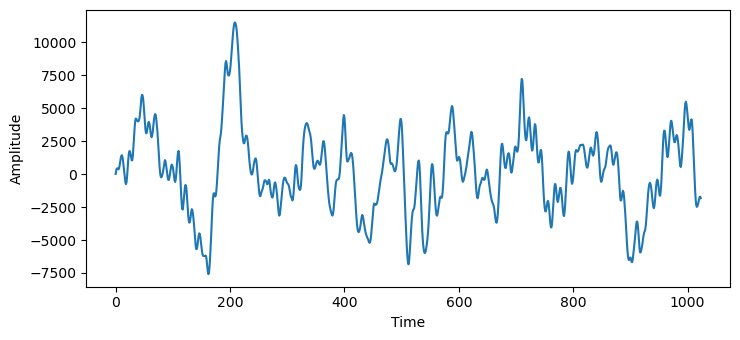

In [3]:
from scipy.io.wavfile import read as rd
import matplotlib.pyplot as plt
audios = os.listdir(DATA_DIR)
test_audio = rd(DATA_DIR + audios[4])
print('Sample Rate:', test_audio[0])
# sampling_rate, data=read_wav("filename.wav")
test_audio_arr = np.array(test_audio[1], dtype=float)


plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.plot(test_audio_arr[0:1024])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

- n_fft: The number of Fourier bins. This should be equal to or greater than the window size.
- sample_rate: The sample rate of the signal in Hz. In your case, it's 16 kHz.
- win_length: The length of the window in samples. This is usually a power of 2. It determines the width of the analysis window in time.
- hop_length: The number of samples to advance between frames. This determines the overlap between successive frames.

In [5]:
# SAMPLING_RATE = 16000 # 44100
# N_FFT = 1024 # 4410

# def extract_spectrogram(values, clip, entries):
#     for data in entries:
#         num_channels = 3
#         window_sizes = [25, 50, 100]
#         hop_sizes = [10, 25, 50]
#         centre_sec = 2.5

#         specs = []
#         for i in range(num_channels):
#             window_length = int((N_FFT / SAMPLING_RATE) * 1000) # int(round(window_sizes[i]*SAMPLING_RATE/1000))
#             hop_length = int(window_length / 2) # int(round(hop_sizes[i]*SAMPLING_RATE/1000))
#             clip = torch.Tensor(clip)
#             spec = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLING_RATE, n_fft=N_FFT, win_length=window_length, hop_length=hop_length, n_mels=128)(clip)
#             eps = 1e-6
#             spec = spec.numpy()
#             spec = np.log(spec+ eps)
#             spec = np.asarray(torchvision.transforms.Resize((128, 250))(Image.fromarray(spec)))
#             specs.append(spec)
#         new_entry = {}
#         new_entry["audio"] = clip.numpy()
#         new_entry["values"] = np.array(specs)
#         new_entry["target"] = data["target"]
#         values.append(new_entry)

# def extract_features(audios):
#     audio_names = list(audios.filename.unique())
#     values = []
#     for audio in audio_names:
#         clip, sr = librosa.load("{}/{}".format(DATA_DIR, audio), sr=SAMPLING_RATE)
#         entries = audios.loc[audios["filename"]==audio].to_dict(orient="records")
#         extract_spectrogram(values, clip, entries)
#         print("Finished audio {}".format(audio))
#     return values


# audios = pd.read_csv(CSV_FILE, skipinitialspace=True)
# num_folds = 5

# for i in range(1, num_folds+1):
#     training_audios = audios.loc[audios["fold"]!=i]
#     validation_audios = audios.loc[audios["fold"]==i]

#     training_values = extract_features(training_audios)
#     with open("{}training128mel{}.pkl".format(STORE_DIR, i),"wb") as handler:
#         pkl.dump(training_values, handler, protocol=pkl.HIGHEST_PROTOCOL)

#     validation_values = extract_features(validation_audios)
#     with open("{}validation128mel{}.pkl".format(STORE_DIR, i),"wb") as handler:
#         pkl.dump(validation_values, handler, protocol=pkl.HIGHEST_PROTOCOL)

## Utilities

In [6]:
class RunningAverage():
    def __init__(self):
        self.total = 0
        self.steps = 0
    def update(self, loss):
        self.total += loss
        self.steps += 1
    def __call__(self):
        return (self.total/float(self.steps))

def save_checkpoint(state, is_best, split, checkpoint):
    filename = os.path.join(checkpoint, 'last{}.pth.tar'.format(split))
    if not os.path.exists(checkpoint):
        print("Checkpoint Directory does not exist")
        os.mkdir(checkpoint)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(checkpoint, "model_best_{}.pth.tar".format(split)))

def load_checkpoint(checkpoint, model, optimizer=None, parallel=False):
    if not os.path.exists(checkpoint):
        raise("File Not Found Error {}".format(checkpoint))
    checkpoint = torch.load(checkpoint)
    if parallel:
        model.module.load_state_dict(checkpoint["model"])
    else:
        model.load_state_dict(checkpoint["model"])

    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer"])
    return checkpoint

def initialize_weights(m):
    classname = m.__class__.__name__
    print(classname)
    if classname.find('Linear') != -1:
        nn.init.ones_(m.weight.data)
        
def evaluate(model, device, test_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            inputs = data[0].to(device)
            target = data[1].squeeze(1).to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return (100*correct/total)

## Model

In [17]:
import torchvision.models as models

class ResNet_Mod(nn.Module):
    def __init__(self, dataset, num_classes, pretrained=True):
        super(ResNet_Mod, self).__init__()
        self.model = models.resnet50(pretrained=pretrained)
        self.model.fc = nn.Linear(2048, 1024)
        self.out = nn.Linear(1024, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.model(x))
        output = self.out(x)
        return output


## Dataloader
No Augumentation

In [18]:
# from torch.utils.data import *
import lmdb

class AudioDataset(Dataset):
    def __init__(self, pkl_dir, dataset_name, transforms=None):
        self.data = []
        self.length = 250
        self.transforms = transforms
        with open(pkl_dir, "rb") as f:
            self.data = pkl.load(f)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        entry = self.data[idx]
        output_data = {}
        values = entry["values"].reshape(-1, 128, self.length)
        values = torch.Tensor(values)
        if self.transforms:
            values = self.transforms(values)
        target = torch.LongTensor([entry["target"]])
        return (values, target)

def fetch_dataloader(pkl_dir, dataset_name, batch_size, num_workers):
    dataset = AudioDataset(pkl_dir, dataset_name)
    dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
    return dataloader

With Augumentation

In [19]:
# from torch.utils.data import *
import lmdb
import random

class MelSpectrogram_aug(object):
    def __init__(self, bins, mode, dataset):
        self.window_length = [25, 50, 100]
        self.hop_length = [10, 25, 50]
        self.fft = 4410 if dataset=="ESC" else 2205
        self.melbins = bins
        self.mode = mode
        self.sr = 44100 if dataset=="ESC" else 22050
        self.length = 250
    def __call__(self, value):
        sample = value
        limits = ((-2, 2), (0.9, 1.2))

        if self.mode=="train":
            pitch_shift = np.random.randint(limits[0][0], limits[0][1] + 1)
            time_stretch = np.random.random() * (limits[1][1] - limits[1][0]) + limits[1][0]
            new_audio = librosa.effects.time_stretch(librosa.effects.pitch_shift(sample, self.sr, pitch_shift), time_stretch)
        else:
            pitch_shift = 0
            time_stretch = 1
            new_audio = sample
        specs = []
        for i in range(len(self.window_length)):
            clip = torch.Tensor(new_audio)

            window_length = int(round(self.window_length[i]*self.sr/1000))
            hop_length = int(round(self.hop_length[i]*self.sr/1000))
            spec = torchaudio.transforms.MelSpectrogram(sample_rate=self.sr, n_fft=self.fft, win_length=window_length, hop_length=hop_length, n_mels=self.melbins)(clip)
            eps = 1e-6
            spec = spec.numpy()
            spec = np.log(spec+ eps)
            spec = np.asarray(torchvision.transforms.Resize((128, self.length))(Image.fromarray(spec)))
            specs.append(spec)
        specs = np.array(specs).reshape(-1, 128, self.length)
        specs = torch.Tensor(specs)
        return specs

class AudioDataset_aug(Dataset):
    def __init__(self, pkl_dir, dataset_name, transforms=None):
        self.transforms = transforms
        self.data = []
        self.length = 250
        with open(pkl_dir, "rb") as f:
            self.data = pkl.load(f)
    def __len__(self):
        if self.transforms.mode == "train":
            return 2*len(self.data)
        else:
            return len(self.data)
    def __getitem__(self, idx):
        if idx >= len(self.data):
            new_idx = idx - len(self.data)
            entry = self.data[new_idx]
            if self.transforms:
                values = self.transforms(entry["audio"])
        else:
            entry = self.data[idx]
            values = torch.Tensor(entry["values"].reshape(-1, 128, self.length))
        target = torch.LongTensor([entry["target"]])
        return (values, target)

def fetch_dataloader_aug(pkl_dir, dataset_name, batch_size, num_workers, mode):
    transforms = MelSpectrogram_aug(128, mode, dataset_name)
    dataset = AudioDataset_aug(pkl_dir, dataset_name, transforms=transforms)
    dataloader = DataLoader(dataset,shuffle=True, batch_size=batch_size, num_workers=num_workers)
    return dataloader

## Training

In [21]:
config_dict = {
    "dataset_name": "ESC",
    "data_dir": "ResNet_Experiment/spectogram_store/",
    "dataaug": False,
    "pretrained": True,
    "scheduler": True,
    "model": "densenet",
    "batch_size": 32,
    "num_workers": 8,
    "epochs": 100,
    "lr": 1e-4,
    "weight_decay": 1e-3,
    "num_folds": 5,
    "checkpoint_dir": "ResNet_Experiment/checkpoint"
}

In [22]:
loss_arr = []
acc_arr = []
def train(model, device, data_loader, optimizer, loss_fn):
    model.train()
    loss_avg = RunningAverage()

    with tqdm(total=len(data_loader)) as t:
        for batch_idx, data in enumerate(data_loader):
            inputs = data[0].to(device)
            target = data[1].squeeze(1).to(device)

            outputs = model(inputs)
            

            loss = loss_fn(outputs, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg.update(loss.item())

            t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
            t.update()
    return loss_avg()


def train_and_evaluate(model, device, train_loader, val_loader, optimizer, loss_fn, params, split, scheduler=None):
    best_acc = 0.0

    for epoch in range(params["epochs"]):
        avg_loss = train(model, device, train_loader, optimizer, loss_fn)

        acc = evaluate(model, device, val_loader)
        
        # Save loss
        loss_arr.append(avg_loss)
        
        acc_arr.append(acc)
        print("Epoch {}/{} Loss:{} Valid Acc:{}".format(epoch, params["epochs"], avg_loss, acc))

        is_best = (acc > best_acc)
        if is_best:
            best_acc = acc
        if scheduler:
            scheduler.step()

        save_checkpoint({"epoch": epoch + 1,
                               "model": model.state_dict(),
                               "optimizer": optimizer.state_dict()}, is_best, split, "{}".format(params["checkpoint_dir"]))
        # writer.add_scalar("data{}/trainingLoss{}".format(params["dataset_name"], split), avg_loss, epoch)
        # writer.add_scalar("data{}/valLoss{}".format(params["dataset_name"], split), acc, epoch)
    # writer.close()


params = config_dict
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for i in range(1, params["num_folds"]+1):
    if params["dataaug"]:
        train_loader = fetch_dataloader_aug( "{}training128mel{}.pkl".format(params["data_dir"], i), params["dataset_name"], params["batch_size"], params["num_workers"], 'train')
        val_loader = fetch_dataloader_aug("{}validation128mel{}.pkl".format(params["data_dir"], i), params["dataset_name"], params["batch_size"], params["num_workers"], 'validation')
    else:
        train_loader = fetch_dataloader( "{}training128mel{}.pkl".format(params["data_dir"], i), params["dataset_name"], params["batch_size"], params["num_workers"])
        val_loader = fetch_dataloader("{}validation128mel{}.pkl".format(params["data_dir"], i), params["dataset_name"], params["batch_size"], params["num_workers"])

    # writer = SummaryWriter(comment=params["dataset_name"])

    model = ResNet_Mod(params["dataset_name"], 50, params["pretrained"]).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])

    if params["scheduler"]:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, gamma=0.1)
    else:
        scheduler = None

    train_and_evaluate(model, device, train_loader, val_loader, optimizer, loss_fn, params, i, scheduler)

100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=3.246]


Epoch 0/100 Loss:3.2459545946121215 Valid Acc:45.75


100%|██████████| 50/50 [00:09<00:00,  5.47it/s, loss=1.578]


Epoch 1/100 Loss:1.5776717281341552 Valid Acc:59.5


100%|██████████| 50/50 [00:09<00:00,  5.49it/s, loss=0.766]


Epoch 2/100 Loss:0.7656065779924393 Valid Acc:66.25


100%|██████████| 50/50 [00:09<00:00,  5.46it/s, loss=0.346]


Epoch 3/100 Loss:0.34608633399009703 Valid Acc:68.75


100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=0.200]


Epoch 4/100 Loss:0.19957511112093926 Valid Acc:73.0


100%|██████████| 50/50 [00:09<00:00,  5.53it/s, loss=0.096]


Epoch 5/100 Loss:0.09594522088766098 Valid Acc:76.75


100%|██████████| 50/50 [00:09<00:00,  5.52it/s, loss=0.067]


Epoch 6/100 Loss:0.06680545911192894 Valid Acc:72.75


100%|██████████| 50/50 [00:09<00:00,  5.45it/s, loss=0.092]


Epoch 7/100 Loss:0.09157656367868185 Valid Acc:73.25


100%|██████████| 50/50 [00:09<00:00,  5.55it/s, loss=0.095]


Epoch 8/100 Loss:0.0946148832142353 Valid Acc:67.25


100%|██████████| 50/50 [00:09<00:00,  5.48it/s, loss=0.146]


Epoch 9/100 Loss:0.14597678001970052 Valid Acc:67.75


100%|██████████| 50/50 [00:08<00:00,  5.58it/s, loss=0.205]


Epoch 10/100 Loss:0.2045719853043556 Valid Acc:74.0


100%|██████████| 50/50 [00:09<00:00,  5.39it/s, loss=0.180]


Epoch 11/100 Loss:0.1801488373428583 Valid Acc:72.25


100%|██████████| 50/50 [00:09<00:00,  5.55it/s, loss=0.096]


Epoch 12/100 Loss:0.09586424134671688 Valid Acc:71.25


100%|██████████| 50/50 [00:09<00:00,  5.48it/s, loss=0.056]


Epoch 13/100 Loss:0.05606402571313083 Valid Acc:73.75


100%|██████████| 50/50 [00:09<00:00,  5.44it/s, loss=0.076]


Epoch 14/100 Loss:0.0760522317700088 Valid Acc:74.25


100%|██████████| 50/50 [00:09<00:00,  5.48it/s, loss=0.042]


Epoch 15/100 Loss:0.042170173535123465 Valid Acc:75.25


100%|██████████| 50/50 [00:09<00:00,  5.47it/s, loss=0.036]


Epoch 16/100 Loss:0.03621887720189989 Valid Acc:75.25


100%|██████████| 50/50 [00:09<00:00,  5.55it/s, loss=0.043]


Epoch 17/100 Loss:0.04310872524511069 Valid Acc:71.0


100%|██████████| 50/50 [00:09<00:00,  5.44it/s, loss=0.062]


Epoch 18/100 Loss:0.062344456259161234 Valid Acc:72.75


100%|██████████| 50/50 [00:09<00:00,  5.40it/s, loss=0.052]


Epoch 19/100 Loss:0.05160303359851241 Valid Acc:74.25


100%|██████████| 50/50 [00:09<00:00,  5.39it/s, loss=0.038]


Epoch 20/100 Loss:0.037533164215274153 Valid Acc:76.25


100%|██████████| 50/50 [00:09<00:00,  5.48it/s, loss=0.050]


Epoch 21/100 Loss:0.04988647437188774 Valid Acc:75.25


100%|██████████| 50/50 [00:09<00:00,  5.50it/s, loss=0.032]


Epoch 22/100 Loss:0.03201193545479328 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.49it/s, loss=0.071]


Epoch 23/100 Loss:0.07074058190453797 Valid Acc:74.0


100%|██████████| 50/50 [00:09<00:00,  5.53it/s, loss=0.077]


Epoch 24/100 Loss:0.0766980487294495 Valid Acc:70.75


100%|██████████| 50/50 [00:09<00:00,  5.40it/s, loss=0.064]


Epoch 25/100 Loss:0.063579605743289 Valid Acc:75.0


100%|██████████| 50/50 [00:09<00:00,  5.50it/s, loss=0.084]


Epoch 26/100 Loss:0.08443078943528234 Valid Acc:75.0


100%|██████████| 50/50 [00:09<00:00,  5.50it/s, loss=0.119]


Epoch 27/100 Loss:0.11915697745978832 Valid Acc:74.0


100%|██████████| 50/50 [00:09<00:00,  5.55it/s, loss=0.081]


Epoch 28/100 Loss:0.08075451935641467 Valid Acc:72.25


100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=0.068]


Epoch 29/100 Loss:0.06820725502446294 Valid Acc:75.0


100%|██████████| 50/50 [00:09<00:00,  5.47it/s, loss=0.034]


Epoch 30/100 Loss:0.034185186736285685 Valid Acc:78.75


100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=0.014]


Epoch 31/100 Loss:0.014390247040428222 Valid Acc:79.75


100%|██████████| 50/50 [00:09<00:00,  5.45it/s, loss=0.008]


Epoch 32/100 Loss:0.008448390485718847 Valid Acc:80.0


100%|██████████| 50/50 [00:09<00:00,  5.46it/s, loss=0.014]


Epoch 33/100 Loss:0.013507141559384763 Valid Acc:81.0


100%|██████████| 50/50 [00:09<00:00,  5.50it/s, loss=0.011]


Epoch 34/100 Loss:0.010536066414788365 Valid Acc:81.0


100%|██████████| 50/50 [00:09<00:00,  5.48it/s, loss=0.009]


Epoch 35/100 Loss:0.009168345869984478 Valid Acc:81.75


100%|██████████| 50/50 [00:09<00:00,  5.53it/s, loss=0.006]


Epoch 36/100 Loss:0.006092463943641633 Valid Acc:81.5


100%|██████████| 50/50 [00:09<00:00,  5.51it/s, loss=0.006]


Epoch 37/100 Loss:0.005876769463066011 Valid Acc:81.75


100%|██████████| 50/50 [00:09<00:00,  5.45it/s, loss=0.006]


Epoch 38/100 Loss:0.005540102482773364 Valid Acc:83.0


100%|██████████| 50/50 [00:09<00:00,  5.50it/s, loss=0.005]


Epoch 39/100 Loss:0.00527238714741543 Valid Acc:82.25


100%|██████████| 50/50 [00:09<00:00,  5.42it/s, loss=0.004]


Epoch 40/100 Loss:0.004414144661277533 Valid Acc:82.0


100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=0.005]


Epoch 41/100 Loss:0.004709140751510858 Valid Acc:81.75


100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=0.004]


Epoch 42/100 Loss:0.004429834512993693 Valid Acc:82.5


100%|██████████| 50/50 [00:09<00:00,  5.50it/s, loss=0.005]


Epoch 43/100 Loss:0.004722836425062269 Valid Acc:81.25


100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=0.004]


Epoch 44/100 Loss:0.0036892697867006064 Valid Acc:81.5


100%|██████████| 50/50 [00:09<00:00,  5.41it/s, loss=0.004]


Epoch 45/100 Loss:0.0036403102218173443 Valid Acc:82.75


100%|██████████| 50/50 [00:09<00:00,  5.45it/s, loss=0.004]


Epoch 46/100 Loss:0.0037574594491161404 Valid Acc:82.25


100%|██████████| 50/50 [00:09<00:00,  5.52it/s, loss=0.004]


Epoch 47/100 Loss:0.00424856893136166 Valid Acc:82.0


100%|██████████| 50/50 [00:09<00:00,  5.48it/s, loss=0.003]


Epoch 48/100 Loss:0.0031081277155317368 Valid Acc:82.0


100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=0.004]


Epoch 49/100 Loss:0.0036793766729533673 Valid Acc:80.75


100%|██████████| 50/50 [00:09<00:00,  5.51it/s, loss=0.004]


Epoch 50/100 Loss:0.003992189585696906 Valid Acc:80.5


100%|██████████| 50/50 [00:09<00:00,  5.45it/s, loss=0.004]


Epoch 51/100 Loss:0.0037890091899316757 Valid Acc:80.25


100%|██████████| 50/50 [00:09<00:00,  5.53it/s, loss=0.004]


Epoch 52/100 Loss:0.003698445903137326 Valid Acc:82.75


100%|██████████| 50/50 [00:09<00:00,  5.47it/s, loss=0.003]


Epoch 53/100 Loss:0.0032936115469783546 Valid Acc:82.5


100%|██████████| 50/50 [00:09<00:00,  5.46it/s, loss=0.003]


Epoch 54/100 Loss:0.0032415791042149067 Valid Acc:81.25


100%|██████████| 50/50 [00:09<00:00,  5.50it/s, loss=0.002]


Epoch 55/100 Loss:0.002462229784578085 Valid Acc:82.25


100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=0.004]


Epoch 56/100 Loss:0.003784562593791634 Valid Acc:81.5


100%|██████████| 50/50 [00:09<00:00,  5.46it/s, loss=0.003]


Epoch 57/100 Loss:0.0031591011921409517 Valid Acc:81.75


100%|██████████| 50/50 [00:09<00:00,  5.46it/s, loss=0.003]


Epoch 58/100 Loss:0.003408340935129672 Valid Acc:82.0


100%|██████████| 50/50 [00:09<00:00,  5.50it/s, loss=0.003]


Epoch 59/100 Loss:0.0026405159267596902 Valid Acc:82.75


100%|██████████| 50/50 [00:09<00:00,  5.47it/s, loss=0.003]


Epoch 60/100 Loss:0.002957928789546713 Valid Acc:81.5


100%|██████████| 50/50 [00:09<00:00,  5.50it/s, loss=0.003]


Epoch 61/100 Loss:0.00283094760729 Valid Acc:82.5


100%|██████████| 50/50 [00:09<00:00,  5.50it/s, loss=0.003]


Epoch 62/100 Loss:0.0032973325834609567 Valid Acc:82.5


100%|██████████| 50/50 [00:09<00:00,  5.41it/s, loss=0.003]


Epoch 63/100 Loss:0.0029066745529416948 Valid Acc:82.25


100%|██████████| 50/50 [00:09<00:00,  5.44it/s, loss=0.003]


Epoch 64/100 Loss:0.0026320437795948237 Valid Acc:82.25


100%|██████████| 50/50 [00:09<00:00,  5.50it/s, loss=0.003]


Epoch 65/100 Loss:0.00254751006141305 Valid Acc:82.5


100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=0.003]


Epoch 66/100 Loss:0.0029771323187742383 Valid Acc:82.75


100%|██████████| 50/50 [00:09<00:00,  5.45it/s, loss=0.003]


Epoch 67/100 Loss:0.003046623506816104 Valid Acc:82.0


100%|██████████| 50/50 [00:09<00:00,  5.46it/s, loss=0.003]


Epoch 68/100 Loss:0.002529625858878717 Valid Acc:82.5


100%|██████████| 50/50 [00:09<00:00,  5.42it/s, loss=0.003]


Epoch 69/100 Loss:0.003094771925825626 Valid Acc:82.5


100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=0.002]


Epoch 70/100 Loss:0.0024215837335214018 Valid Acc:82.0


100%|██████████| 50/50 [00:09<00:00,  5.50it/s, loss=0.003]


Epoch 71/100 Loss:0.003069185282802209 Valid Acc:81.75


100%|██████████| 50/50 [00:09<00:00,  5.44it/s, loss=0.003]


Epoch 72/100 Loss:0.0030265936895739285 Valid Acc:83.25


100%|██████████| 50/50 [00:09<00:00,  5.45it/s, loss=0.002]


Epoch 73/100 Loss:0.0024682150839362292 Valid Acc:83.75


100%|██████████| 50/50 [00:09<00:00,  5.49it/s, loss=0.002]


Epoch 74/100 Loss:0.0024434505426324904 Valid Acc:81.75


100%|██████████| 50/50 [00:09<00:00,  5.36it/s, loss=0.002]


Epoch 75/100 Loss:0.0024600356037262827 Valid Acc:82.0


100%|██████████| 50/50 [00:09<00:00,  5.45it/s, loss=0.002]


Epoch 76/100 Loss:0.0024977170047350227 Valid Acc:82.75


100%|██████████| 50/50 [00:09<00:00,  5.48it/s, loss=0.004]


Epoch 77/100 Loss:0.003513898174278438 Valid Acc:82.0


100%|██████████| 50/50 [00:09<00:00,  5.50it/s, loss=0.002]


Epoch 78/100 Loss:0.0024633791646920143 Valid Acc:83.0


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.003]


Epoch 79/100 Loss:0.0025975175912026317 Valid Acc:82.5


100%|██████████| 50/50 [00:09<00:00,  5.40it/s, loss=0.003]


Epoch 80/100 Loss:0.003466762057505548 Valid Acc:81.0


100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=0.004]


Epoch 81/100 Loss:0.0036125308042392135 Valid Acc:82.5


100%|██████████| 50/50 [00:09<00:00,  5.49it/s, loss=0.003]


Epoch 82/100 Loss:0.00349007751327008 Valid Acc:82.25


100%|██████████| 50/50 [00:09<00:00,  5.53it/s, loss=0.003]


Epoch 83/100 Loss:0.002912331090774387 Valid Acc:83.0


100%|██████████| 50/50 [00:09<00:00,  5.40it/s, loss=0.003]


Epoch 84/100 Loss:0.003126116106286645 Valid Acc:82.75


100%|██████████| 50/50 [00:09<00:00,  5.39it/s, loss=0.003]


Epoch 85/100 Loss:0.00281690796953626 Valid Acc:82.0


100%|██████████| 50/50 [00:09<00:00,  5.53it/s, loss=0.003]


Epoch 86/100 Loss:0.002715648349840194 Valid Acc:82.25


100%|██████████| 50/50 [00:09<00:00,  5.40it/s, loss=0.003]


Epoch 87/100 Loss:0.002996393855428323 Valid Acc:82.25


100%|██████████| 50/50 [00:09<00:00,  5.50it/s, loss=0.003]


Epoch 88/100 Loss:0.0030215979809872806 Valid Acc:83.0


100%|██████████| 50/50 [00:09<00:00,  5.39it/s, loss=0.003]


Epoch 89/100 Loss:0.002799012856557965 Valid Acc:83.25


100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=0.003]


Epoch 90/100 Loss:0.0029236400441732258 Valid Acc:81.25


100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=0.002]


Epoch 91/100 Loss:0.0023910689214244486 Valid Acc:82.75


100%|██████████| 50/50 [00:09<00:00,  5.47it/s, loss=0.004]


Epoch 92/100 Loss:0.0035767658380791547 Valid Acc:82.75


100%|██████████| 50/50 [00:09<00:00,  5.44it/s, loss=0.002]


Epoch 93/100 Loss:0.0024898331449367105 Valid Acc:82.25


100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=0.003]


Epoch 94/100 Loss:0.0027441529696807265 Valid Acc:83.25


100%|██████████| 50/50 [00:08<00:00,  5.56it/s, loss=0.003]


Epoch 95/100 Loss:0.002619598247110844 Valid Acc:81.5


100%|██████████| 50/50 [00:09<00:00,  5.47it/s, loss=0.003]


Epoch 96/100 Loss:0.0029686992219649256 Valid Acc:81.75


100%|██████████| 50/50 [00:09<00:00,  5.38it/s, loss=0.003]


Epoch 97/100 Loss:0.0026994511892553417 Valid Acc:82.5


100%|██████████| 50/50 [00:08<00:00,  5.57it/s, loss=0.003]


Epoch 98/100 Loss:0.0028730516089126466 Valid Acc:82.25


100%|██████████| 50/50 [00:09<00:00,  5.44it/s, loss=0.003]


Epoch 99/100 Loss:0.0030736712319776416 Valid Acc:81.75


100%|██████████| 50/50 [00:09<00:00,  5.36it/s, loss=3.263]


Epoch 0/100 Loss:3.2628963708877565 Valid Acc:39.5


100%|██████████| 50/50 [00:09<00:00,  5.31it/s, loss=1.635]


Epoch 1/100 Loss:1.6352864956855775 Valid Acc:64.25


100%|██████████| 50/50 [00:09<00:00,  5.36it/s, loss=0.763]


Epoch 2/100 Loss:0.7625735288858414 Valid Acc:65.25


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.368]


Epoch 3/100 Loss:0.36829221606254575 Valid Acc:73.75


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.229]


Epoch 4/100 Loss:0.2293776623904705 Valid Acc:69.5


100%|██████████| 50/50 [00:09<00:00,  5.29it/s, loss=0.151]


Epoch 5/100 Loss:0.1507010405510664 Valid Acc:71.0


100%|██████████| 50/50 [00:09<00:00,  5.30it/s, loss=0.162]


Epoch 6/100 Loss:0.16211123194545507 Valid Acc:71.0


100%|██████████| 50/50 [00:09<00:00,  5.35it/s, loss=0.100]


Epoch 7/100 Loss:0.10001332685351372 Valid Acc:72.5


100%|██████████| 50/50 [00:09<00:00,  5.35it/s, loss=0.094]


Epoch 8/100 Loss:0.09380726065486669 Valid Acc:69.0


100%|██████████| 50/50 [00:09<00:00,  5.34it/s, loss=0.108]


Epoch 9/100 Loss:0.10751585714519024 Valid Acc:73.5


100%|██████████| 50/50 [00:09<00:00,  5.34it/s, loss=0.081]


Epoch 10/100 Loss:0.0808822214230895 Valid Acc:76.5


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.078]


Epoch 11/100 Loss:0.07788183104246854 Valid Acc:73.0


100%|██████████| 50/50 [00:09<00:00,  5.40it/s, loss=0.043]


Epoch 12/100 Loss:0.04263525934889913 Valid Acc:74.5


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.058]


Epoch 13/100 Loss:0.05820024597458542 Valid Acc:70.5


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.042]


Epoch 14/100 Loss:0.04225559863261878 Valid Acc:74.5


100%|██████████| 50/50 [00:09<00:00,  5.39it/s, loss=0.053]


Epoch 15/100 Loss:0.05253162205219269 Valid Acc:75.75


100%|██████████| 50/50 [00:09<00:00,  5.34it/s, loss=0.040]


Epoch 16/100 Loss:0.03994028935674578 Valid Acc:72.0


100%|██████████| 50/50 [00:09<00:00,  5.31it/s, loss=0.085]


Epoch 17/100 Loss:0.08479833916760982 Valid Acc:72.75


100%|██████████| 50/50 [00:09<00:00,  5.31it/s, loss=0.099]


Epoch 18/100 Loss:0.09855107614770532 Valid Acc:72.75


100%|██████████| 50/50 [00:09<00:00,  5.34it/s, loss=0.087]


Epoch 19/100 Loss:0.08667577357962727 Valid Acc:72.0


100%|██████████| 50/50 [00:09<00:00,  5.38it/s, loss=0.089]


Epoch 20/100 Loss:0.08861781690269709 Valid Acc:69.25


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.091]


Epoch 21/100 Loss:0.09149731119163335 Valid Acc:69.0


100%|██████████| 50/50 [00:09<00:00,  5.41it/s, loss=0.089]


Epoch 22/100 Loss:0.08913640555925667 Valid Acc:73.0


100%|██████████| 50/50 [00:09<00:00,  5.39it/s, loss=0.122]


Epoch 23/100 Loss:0.12215591969899833 Valid Acc:66.75


100%|██████████| 50/50 [00:09<00:00,  5.38it/s, loss=0.121]


Epoch 24/100 Loss:0.12054632007144392 Valid Acc:62.25


100%|██████████| 50/50 [00:09<00:00,  5.34it/s, loss=0.069]


Epoch 25/100 Loss:0.06902722701430321 Valid Acc:74.0


100%|██████████| 50/50 [00:09<00:00,  5.36it/s, loss=0.035]


Epoch 26/100 Loss:0.035211286388803276 Valid Acc:70.0


100%|██████████| 50/50 [00:09<00:00,  5.42it/s, loss=0.045]


Epoch 27/100 Loss:0.04467309237923473 Valid Acc:73.5


100%|██████████| 50/50 [00:09<00:00,  5.42it/s, loss=0.017]


Epoch 28/100 Loss:0.017194069763645528 Valid Acc:76.5


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.022]


Epoch 29/100 Loss:0.022100523479748516 Valid Acc:78.25


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.015]


Epoch 30/100 Loss:0.015132533416617662 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.38it/s, loss=0.008]


Epoch 31/100 Loss:0.0079597679967992 Valid Acc:78.5


100%|██████████| 50/50 [00:09<00:00,  5.37it/s, loss=0.006]


Epoch 32/100 Loss:0.006417460958473385 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.37it/s, loss=0.004]


Epoch 33/100 Loss:0.004048657777020708 Valid Acc:78.75


100%|██████████| 50/50 [00:09<00:00,  5.36it/s, loss=0.006]


Epoch 34/100 Loss:0.005608451378066093 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.31it/s, loss=0.005]


Epoch 35/100 Loss:0.005242724303388968 Valid Acc:80.0


100%|██████████| 50/50 [00:09<00:00,  5.36it/s, loss=0.004]


Epoch 36/100 Loss:0.003811412845971063 Valid Acc:80.0


100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=0.004]


Epoch 37/100 Loss:0.0038079848734196274 Valid Acc:78.75


100%|██████████| 50/50 [00:09<00:00,  5.35it/s, loss=0.004]


Epoch 38/100 Loss:0.0041860125167295335 Valid Acc:78.5


100%|██████████| 50/50 [00:09<00:00,  5.40it/s, loss=0.005]


Epoch 39/100 Loss:0.005134814949706197 Valid Acc:78.0


100%|██████████| 50/50 [00:09<00:00,  5.39it/s, loss=0.005]


Epoch 40/100 Loss:0.004544403831241653 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.38it/s, loss=0.004]


Epoch 41/100 Loss:0.004058683867333457 Valid Acc:79.75


100%|██████████| 50/50 [00:09<00:00,  5.40it/s, loss=0.003]


Epoch 42/100 Loss:0.002624442366650328 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.36it/s, loss=0.003]


Epoch 43/100 Loss:0.0033822931291069835 Valid Acc:78.75


100%|██████████| 50/50 [00:09<00:00,  5.39it/s, loss=0.004]


Epoch 44/100 Loss:0.003868785963859409 Valid Acc:78.75


100%|██████████| 50/50 [00:09<00:00,  5.47it/s, loss=0.004]


Epoch 45/100 Loss:0.004280353406211361 Valid Acc:78.5


100%|██████████| 50/50 [00:09<00:00,  5.34it/s, loss=0.003]


Epoch 46/100 Loss:0.0027207235898822546 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.39it/s, loss=0.003]


Epoch 47/100 Loss:0.0027312303788494317 Valid Acc:78.5


100%|██████████| 50/50 [00:09<00:00,  5.37it/s, loss=0.003]


Epoch 48/100 Loss:0.0032357331283856183 Valid Acc:80.0


100%|██████████| 50/50 [00:09<00:00,  5.36it/s, loss=0.003]


Epoch 49/100 Loss:0.0031510376976802944 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.47it/s, loss=0.003]


Epoch 50/100 Loss:0.002501002069329843 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.43it/s, loss=0.003]


Epoch 51/100 Loss:0.002698093177750707 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.36it/s, loss=0.004]


Epoch 52/100 Loss:0.0038748260401189325 Valid Acc:81.0


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.002]


Epoch 53/100 Loss:0.002120479930890724 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.34it/s, loss=0.003]


Epoch 54/100 Loss:0.0034689644246827813 Valid Acc:79.0


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.003]


Epoch 55/100 Loss:0.0027578009583521636 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.22it/s, loss=0.003]


Epoch 56/100 Loss:0.002966285995207727 Valid Acc:80.0


100%|██████████| 50/50 [00:09<00:00,  5.39it/s, loss=0.002]


Epoch 57/100 Loss:0.0022815247683320196 Valid Acc:79.75


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.003]


Epoch 58/100 Loss:0.003423434420255944 Valid Acc:80.0


100%|██████████| 50/50 [00:09<00:00,  5.28it/s, loss=0.003]


Epoch 59/100 Loss:0.0032777812099084257 Valid Acc:80.75


100%|██████████| 50/50 [00:09<00:00,  5.37it/s, loss=0.002]


Epoch 60/100 Loss:0.0024561345111578704 Valid Acc:79.75


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.003]


Epoch 61/100 Loss:0.0026676214777398856 Valid Acc:80.5


100%|██████████| 50/50 [00:09<00:00,  5.42it/s, loss=0.003]


Epoch 62/100 Loss:0.003169444854138419 Valid Acc:79.75


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.003]


Epoch 63/100 Loss:0.0026185301516670734 Valid Acc:80.25


100%|██████████| 50/50 [00:09<00:00,  5.26it/s, loss=0.003]


Epoch 64/100 Loss:0.002683207927038893 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.37it/s, loss=0.002]


Epoch 65/100 Loss:0.0020210879982914777 Valid Acc:78.75


100%|██████████| 50/50 [00:09<00:00,  5.45it/s, loss=0.002]


Epoch 66/100 Loss:0.0024329878867138176 Valid Acc:80.75


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.002]


Epoch 67/100 Loss:0.002260718500474468 Valid Acc:79.75


100%|██████████| 50/50 [00:09<00:00,  5.47it/s, loss=0.002]


Epoch 68/100 Loss:0.0022827072895597665 Valid Acc:80.0


100%|██████████| 50/50 [00:09<00:00,  5.38it/s, loss=0.002]


Epoch 69/100 Loss:0.0024638847389724106 Valid Acc:79.75


100%|██████████| 50/50 [00:09<00:00,  5.30it/s, loss=0.003]


Epoch 70/100 Loss:0.003303067871602252 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.002]


Epoch 71/100 Loss:0.002113864063285291 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.35it/s, loss=0.002]


Epoch 72/100 Loss:0.0024728311761282383 Valid Acc:79.0


100%|██████████| 50/50 [00:09<00:00,  5.38it/s, loss=0.003]


Epoch 73/100 Loss:0.002662773185875267 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.31it/s, loss=0.002]


Epoch 74/100 Loss:0.0023279301624279467 Valid Acc:79.75


100%|██████████| 50/50 [00:09<00:00,  5.40it/s, loss=0.003]


Epoch 75/100 Loss:0.0033814534393604846 Valid Acc:80.0


100%|██████████| 50/50 [00:09<00:00,  5.41it/s, loss=0.003]


Epoch 76/100 Loss:0.002631342118838802 Valid Acc:79.75


100%|██████████| 50/50 [00:09<00:00,  5.36it/s, loss=0.002]


Epoch 77/100 Loss:0.0023479654476977886 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.36it/s, loss=0.003]


Epoch 78/100 Loss:0.0027803353092167526 Valid Acc:80.5


100%|██████████| 50/50 [00:09<00:00,  5.41it/s, loss=0.002]


Epoch 79/100 Loss:0.002232791160931811 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.29it/s, loss=0.002]


Epoch 80/100 Loss:0.002152541725663468 Valid Acc:80.0


100%|██████████| 50/50 [00:09<00:00,  5.40it/s, loss=0.003]


Epoch 81/100 Loss:0.002785988135728985 Valid Acc:80.0


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.002]


Epoch 82/100 Loss:0.002051433410961181 Valid Acc:80.0


100%|██████████| 50/50 [00:09<00:00,  5.31it/s, loss=0.002]


Epoch 83/100 Loss:0.0023616241302806882 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.37it/s, loss=0.002]


Epoch 84/100 Loss:0.0021103676629718395 Valid Acc:80.25


100%|██████████| 50/50 [00:09<00:00,  5.40it/s, loss=0.002]


Epoch 85/100 Loss:0.0020214111101813613 Valid Acc:79.0


100%|██████████| 50/50 [00:09<00:00,  5.29it/s, loss=0.002]


Epoch 86/100 Loss:0.0022745340585242956 Valid Acc:79.75


100%|██████████| 50/50 [00:09<00:00,  5.28it/s, loss=0.002]


Epoch 87/100 Loss:0.001931695577222854 Valid Acc:79.75


100%|██████████| 50/50 [00:09<00:00,  5.34it/s, loss=0.002]


Epoch 88/100 Loss:0.0019899407553020864 Valid Acc:80.75


100%|██████████| 50/50 [00:09<00:00,  5.45it/s, loss=0.002]


Epoch 89/100 Loss:0.0020251024921890347 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.27it/s, loss=0.002]


Epoch 90/100 Loss:0.002075904858065769 Valid Acc:80.25


100%|██████████| 50/50 [00:09<00:00,  5.36it/s, loss=0.003]


Epoch 91/100 Loss:0.0025072101410478355 Valid Acc:79.75


100%|██████████| 50/50 [00:09<00:00,  5.31it/s, loss=0.003]


Epoch 92/100 Loss:0.002727571700233966 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.002]


Epoch 93/100 Loss:0.0023459293670021 Valid Acc:80.25


100%|██████████| 50/50 [00:09<00:00,  5.42it/s, loss=0.002]


Epoch 94/100 Loss:0.0022793196234852076 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.38it/s, loss=0.003]


Epoch 95/100 Loss:0.002662185189547017 Valid Acc:81.25


100%|██████████| 50/50 [00:09<00:00,  5.35it/s, loss=0.002]


Epoch 96/100 Loss:0.0020482985791750253 Valid Acc:80.0


100%|██████████| 50/50 [00:09<00:00,  5.27it/s, loss=0.002]


Epoch 97/100 Loss:0.0023566864675376564 Valid Acc:79.0


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.002]


Epoch 98/100 Loss:0.0020474368217401205 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.002]


Epoch 99/100 Loss:0.0023703041952103376 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.29it/s, loss=3.228]


Epoch 0/100 Loss:3.228463430404663 Valid Acc:46.75


100%|██████████| 50/50 [00:09<00:00,  5.34it/s, loss=1.557]


Epoch 1/100 Loss:1.5565975642204284 Valid Acc:58.5


100%|██████████| 50/50 [00:09<00:00,  5.41it/s, loss=0.730]


Epoch 2/100 Loss:0.7304567074775696 Valid Acc:66.0


100%|██████████| 50/50 [00:09<00:00,  5.35it/s, loss=0.381]


Epoch 3/100 Loss:0.38130964696407316 Valid Acc:64.5


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.199]


Epoch 4/100 Loss:0.1989252120256424 Valid Acc:71.25


100%|██████████| 50/50 [00:09<00:00,  5.40it/s, loss=0.168]


Epoch 5/100 Loss:0.16839691013097763 Valid Acc:70.5


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.164]


Epoch 6/100 Loss:0.16366059616208076 Valid Acc:70.0


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.117]


Epoch 7/100 Loss:0.11658212408423424 Valid Acc:73.5


100%|██████████| 50/50 [00:09<00:00,  5.31it/s, loss=0.072]


Epoch 8/100 Loss:0.07218729741871358 Valid Acc:74.5


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.085]


Epoch 9/100 Loss:0.08509849550202489 Valid Acc:72.0


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.059]


Epoch 10/100 Loss:0.05853325502946973 Valid Acc:72.25


100%|██████████| 50/50 [00:09<00:00,  5.38it/s, loss=0.054]


Epoch 11/100 Loss:0.054450171887874606 Valid Acc:75.0


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.056]


Epoch 12/100 Loss:0.056322152460925284 Valid Acc:76.75


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.051]


Epoch 13/100 Loss:0.051181522235274314 Valid Acc:79.75


100%|██████████| 50/50 [00:09<00:00,  5.31it/s, loss=0.042]


Epoch 14/100 Loss:0.04196240834426135 Valid Acc:72.5


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.084]


Epoch 15/100 Loss:0.08358082722872495 Valid Acc:71.5


100%|██████████| 50/50 [00:09<00:00,  5.42it/s, loss=0.117]


Epoch 16/100 Loss:0.11734684344381094 Valid Acc:67.5


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.148]


Epoch 17/100 Loss:0.14823010355234145 Valid Acc:64.5


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.172]


Epoch 18/100 Loss:0.17156464288011194 Valid Acc:69.75


100%|██████████| 50/50 [00:09<00:00,  5.41it/s, loss=0.115]


Epoch 19/100 Loss:0.11545522887259722 Valid Acc:72.5


100%|██████████| 50/50 [00:09<00:00,  5.36it/s, loss=0.094]


Epoch 20/100 Loss:0.09376639673486352 Valid Acc:74.5


100%|██████████| 50/50 [00:09<00:00,  5.37it/s, loss=0.040]


Epoch 21/100 Loss:0.040435919989831745 Valid Acc:74.75


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.060]


Epoch 22/100 Loss:0.06029713158495724 Valid Acc:70.5


100%|██████████| 50/50 [00:09<00:00,  5.35it/s, loss=0.068]


Epoch 23/100 Loss:0.0682595187611878 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.28it/s, loss=0.033]


Epoch 24/100 Loss:0.03288565195631236 Valid Acc:74.75


100%|██████████| 50/50 [00:09<00:00,  5.29it/s, loss=0.030]


Epoch 25/100 Loss:0.029755261996760964 Valid Acc:75.25


100%|██████████| 50/50 [00:09<00:00,  5.35it/s, loss=0.029]


Epoch 26/100 Loss:0.029283688352443278 Valid Acc:76.25


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.031]


Epoch 27/100 Loss:0.031217540316283703 Valid Acc:77.5


100%|██████████| 50/50 [00:09<00:00,  5.38it/s, loss=0.032]


Epoch 28/100 Loss:0.0323645771946758 Valid Acc:72.75


100%|██████████| 50/50 [00:09<00:00,  5.30it/s, loss=0.045]


Epoch 29/100 Loss:0.044732268410734834 Valid Acc:74.5


100%|██████████| 50/50 [00:09<00:00,  5.30it/s, loss=0.021]


Epoch 30/100 Loss:0.020613554678857327 Valid Acc:74.75


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.011]


Epoch 31/100 Loss:0.011453888318501413 Valid Acc:77.0


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.007]


Epoch 32/100 Loss:0.00672957100905478 Valid Acc:76.0


100%|██████████| 50/50 [00:09<00:00,  5.27it/s, loss=0.006]


Epoch 33/100 Loss:0.006026160104665905 Valid Acc:77.5


100%|██████████| 50/50 [00:09<00:00,  5.25it/s, loss=0.008]


Epoch 34/100 Loss:0.00755741975735873 Valid Acc:77.0


100%|██████████| 50/50 [00:09<00:00,  5.35it/s, loss=0.006]


Epoch 35/100 Loss:0.006045252436306328 Valid Acc:77.25


100%|██████████| 50/50 [00:09<00:00,  5.30it/s, loss=0.006]


Epoch 36/100 Loss:0.005861640358343721 Valid Acc:78.25


100%|██████████| 50/50 [00:09<00:00,  5.30it/s, loss=0.005]


Epoch 37/100 Loss:0.004712398599367589 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.26it/s, loss=0.005]


Epoch 38/100 Loss:0.00515433450229466 Valid Acc:77.75


100%|██████████| 50/50 [00:09<00:00,  5.38it/s, loss=0.005]


Epoch 39/100 Loss:0.00485956801334396 Valid Acc:79.0


100%|██████████| 50/50 [00:09<00:00,  5.29it/s, loss=0.005]


Epoch 40/100 Loss:0.004714577249251306 Valid Acc:78.25


100%|██████████| 50/50 [00:09<00:00,  5.24it/s, loss=0.005]


Epoch 41/100 Loss:0.004728747158078477 Valid Acc:78.75


100%|██████████| 50/50 [00:09<00:00,  5.30it/s, loss=0.005]


Epoch 42/100 Loss:0.00478012912790291 Valid Acc:78.75


100%|██████████| 50/50 [00:09<00:00,  5.36it/s, loss=0.003]


Epoch 43/100 Loss:0.0034341161325573922 Valid Acc:78.75


100%|██████████| 50/50 [00:09<00:00,  5.41it/s, loss=0.004]


Epoch 44/100 Loss:0.003615106416400522 Valid Acc:78.5


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.003]


Epoch 45/100 Loss:0.0032801466225646438 Valid Acc:77.75


100%|██████████| 50/50 [00:09<00:00,  5.35it/s, loss=0.003]


Epoch 46/100 Loss:0.003239536837209016 Valid Acc:78.0


100%|██████████| 50/50 [00:09<00:00,  5.23it/s, loss=0.004]


Epoch 47/100 Loss:0.004104061961406842 Valid Acc:79.0


100%|██████████| 50/50 [00:09<00:00,  5.30it/s, loss=0.004]


Epoch 48/100 Loss:0.00410068737808615 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.27it/s, loss=0.004]


Epoch 49/100 Loss:0.003832858013920486 Valid Acc:79.0


100%|██████████| 50/50 [00:09<00:00,  5.23it/s, loss=0.004]


Epoch 50/100 Loss:0.0036018035863526164 Valid Acc:78.5


100%|██████████| 50/50 [00:09<00:00,  5.35it/s, loss=0.003]


Epoch 51/100 Loss:0.0030537565075792372 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.34it/s, loss=0.003]


Epoch 52/100 Loss:0.003464759353082627 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.34it/s, loss=0.004]


Epoch 53/100 Loss:0.0038051931862719355 Valid Acc:79.0


100%|██████████| 50/50 [00:09<00:00,  5.27it/s, loss=0.003]


Epoch 54/100 Loss:0.003333721294766292 Valid Acc:77.25


100%|██████████| 50/50 [00:09<00:00,  5.36it/s, loss=0.003]


Epoch 55/100 Loss:0.0027471168455667793 Valid Acc:78.5


100%|██████████| 50/50 [00:09<00:00,  5.34it/s, loss=0.003]


Epoch 56/100 Loss:0.0031731953111011537 Valid Acc:79.0


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.003]


Epoch 57/100 Loss:0.002616959852166474 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.31it/s, loss=0.003]


Epoch 58/100 Loss:0.0026578012271784245 Valid Acc:78.5


100%|██████████| 50/50 [00:09<00:00,  5.24it/s, loss=0.003]


Epoch 59/100 Loss:0.0027136291353963317 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.003]


Epoch 60/100 Loss:0.002590314274420962 Valid Acc:79.0


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.003]


Epoch 61/100 Loss:0.003100420257542282 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.29it/s, loss=0.003]


Epoch 62/100 Loss:0.0026519055641256273 Valid Acc:78.25


100%|██████████| 50/50 [00:09<00:00,  5.27it/s, loss=0.003]


Epoch 63/100 Loss:0.0030052006733603774 Valid Acc:78.25


100%|██████████| 50/50 [00:09<00:00,  5.24it/s, loss=0.003]


Epoch 64/100 Loss:0.0031157292472198607 Valid Acc:78.75


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.003]


Epoch 65/100 Loss:0.003142750961706042 Valid Acc:80.75


100%|██████████| 50/50 [00:09<00:00,  5.38it/s, loss=0.003]


Epoch 66/100 Loss:0.0026896603987552224 Valid Acc:78.75


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.003]


Epoch 67/100 Loss:0.003080751548986882 Valid Acc:78.75


100%|██████████| 50/50 [00:09<00:00,  5.39it/s, loss=0.003]


Epoch 68/100 Loss:0.0029157900798600167 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.31it/s, loss=0.002]


Epoch 69/100 Loss:0.002183265152852982 Valid Acc:80.0


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.003]


Epoch 70/100 Loss:0.0026832751627080143 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.29it/s, loss=0.002]


Epoch 71/100 Loss:0.0024875881720799954 Valid Acc:79.5


100%|██████████| 50/50 [00:09<00:00,  5.30it/s, loss=0.002]


Epoch 72/100 Loss:0.0021524312207475303 Valid Acc:79.0


100%|██████████| 50/50 [00:09<00:00,  5.30it/s, loss=0.003]


Epoch 73/100 Loss:0.0025001286063343286 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.34it/s, loss=0.003]


Epoch 74/100 Loss:0.0028527920809574424 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.003]


Epoch 75/100 Loss:0.0030709948134608565 Valid Acc:79.25


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.003]


Epoch 53/100 Loss:0.0028419639286585154 Valid Acc:77.0


100%|██████████| 50/50 [00:09<00:00,  5.27it/s, loss=0.003]


Epoch 54/100 Loss:0.0033734157809522003 Valid Acc:76.75


100%|██████████| 50/50 [00:09<00:00,  5.31it/s, loss=0.003]


Epoch 55/100 Loss:0.0028791836719028654 Valid Acc:77.5


100%|██████████| 50/50 [00:09<00:00,  5.30it/s, loss=0.002]


Epoch 56/100 Loss:0.0021817541169002652 Valid Acc:77.5


100%|██████████| 50/50 [00:09<00:00,  5.31it/s, loss=0.003]


Epoch 57/100 Loss:0.003117298976285383 Valid Acc:77.5


100%|██████████| 50/50 [00:09<00:00,  5.31it/s, loss=0.003]


Epoch 58/100 Loss:0.002767536942847073 Valid Acc:77.0


100%|██████████| 50/50 [00:09<00:00,  5.27it/s, loss=0.003]


Epoch 59/100 Loss:0.003192469731438905 Valid Acc:77.25


100%|██████████| 50/50 [00:09<00:00,  5.34it/s, loss=0.003]


Epoch 60/100 Loss:0.0026539896812755614 Valid Acc:77.5


100%|██████████| 50/50 [00:09<00:00,  5.35it/s, loss=0.004]


Epoch 61/100 Loss:0.0036737520806491373 Valid Acc:77.75


100%|██████████| 50/50 [00:09<00:00,  5.36it/s, loss=0.003]


Epoch 62/100 Loss:0.0026936742232646794 Valid Acc:77.5


100%|██████████| 50/50 [00:09<00:00,  5.28it/s, loss=0.003]


Epoch 63/100 Loss:0.0027029397059232 Valid Acc:77.75


100%|██████████| 50/50 [00:09<00:00,  5.25it/s, loss=0.002]


Epoch 64/100 Loss:0.0024291645968332887 Valid Acc:77.0


100%|██████████| 50/50 [00:09<00:00,  5.28it/s, loss=0.003]


Epoch 65/100 Loss:0.003489281189395115 Valid Acc:77.25


100%|██████████| 50/50 [00:09<00:00,  5.27it/s, loss=0.003]


Epoch 66/100 Loss:0.002564180033514276 Valid Acc:77.0


100%|██████████| 50/50 [00:09<00:00,  5.31it/s, loss=0.003]


Epoch 67/100 Loss:0.002921005511889234 Valid Acc:77.25


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.003]


Epoch 68/100 Loss:0.00299769785720855 Valid Acc:77.25


100%|██████████| 50/50 [00:09<00:00,  5.29it/s, loss=0.003]


Epoch 69/100 Loss:0.00287199723534286 Valid Acc:76.5


100%|██████████| 50/50 [00:09<00:00,  5.30it/s, loss=0.002]


Epoch 70/100 Loss:0.002289593800669536 Valid Acc:77.25


100%|██████████| 50/50 [00:09<00:00,  5.25it/s, loss=0.003]


Epoch 71/100 Loss:0.002563916912768036 Valid Acc:77.75


100%|██████████| 50/50 [00:09<00:00,  5.28it/s, loss=0.003]


Epoch 72/100 Loss:0.0034570575365796686 Valid Acc:76.75


100%|██████████| 50/50 [00:09<00:00,  5.25it/s, loss=0.003]


Epoch 73/100 Loss:0.0025007109402213246 Valid Acc:77.5


100%|██████████| 50/50 [00:09<00:00,  5.27it/s, loss=0.003]


Epoch 74/100 Loss:0.003233836970757693 Valid Acc:78.0


100%|██████████| 50/50 [00:09<00:00,  5.30it/s, loss=0.003]


Epoch 75/100 Loss:0.0027976483840029685 Valid Acc:78.0


100%|██████████| 50/50 [00:09<00:00,  5.23it/s, loss=0.003]


Epoch 76/100 Loss:0.0029914658318739382 Valid Acc:77.25


100%|██████████| 50/50 [00:09<00:00,  5.26it/s, loss=0.003]


Epoch 77/100 Loss:0.002933655115775764 Valid Acc:77.25


100%|██████████| 50/50 [00:09<00:00,  5.23it/s, loss=0.003]


Epoch 78/100 Loss:0.002851140345446765 Valid Acc:78.0


100%|██████████| 50/50 [00:09<00:00,  5.28it/s, loss=0.003]


Epoch 79/100 Loss:0.002694722772575915 Valid Acc:77.5


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.002]


Epoch 80/100 Loss:0.0019952728401403876 Valid Acc:78.5


100%|██████████| 50/50 [00:09<00:00,  5.33it/s, loss=0.003]


Epoch 81/100 Loss:0.0028741721832193433 Valid Acc:77.5


100%|██████████| 50/50 [00:09<00:00,  5.34it/s, loss=0.002]


Epoch 82/100 Loss:0.002481587273068726 Valid Acc:76.75


100%|██████████| 50/50 [00:09<00:00,  5.26it/s, loss=0.002]


Epoch 83/100 Loss:0.002113310551503673 Valid Acc:76.5


100%|██████████| 50/50 [00:09<00:00,  5.23it/s, loss=0.003]


Epoch 84/100 Loss:0.003421436597127467 Valid Acc:76.75


100%|██████████| 50/50 [00:09<00:00,  5.30it/s, loss=0.004]


Epoch 85/100 Loss:0.003733722826000303 Valid Acc:77.0


100%|██████████| 50/50 [00:09<00:00,  5.24it/s, loss=0.003]


Epoch 86/100 Loss:0.002801090070279315 Valid Acc:77.5


100%|██████████| 50/50 [00:09<00:00,  5.29it/s, loss=0.003]


Epoch 87/100 Loss:0.0028711671894416212 Valid Acc:77.25


100%|██████████| 50/50 [00:09<00:00,  5.23it/s, loss=0.002]


Epoch 88/100 Loss:0.0023863123217597606 Valid Acc:78.0


100%|██████████| 50/50 [00:09<00:00,  5.27it/s, loss=0.003]


Epoch 89/100 Loss:0.002771123205311596 Valid Acc:77.75


100%|██████████| 50/50 [00:09<00:00,  5.23it/s, loss=0.002]


Epoch 90/100 Loss:0.002323852542322129 Valid Acc:76.75


100%|██████████| 50/50 [00:09<00:00,  5.31it/s, loss=0.002]


Epoch 91/100 Loss:0.002365440003341064 Valid Acc:76.75


100%|██████████| 50/50 [00:09<00:00,  5.26it/s, loss=0.003]


Epoch 92/100 Loss:0.0026414895849302413 Valid Acc:77.0


100%|██████████| 50/50 [00:09<00:00,  5.28it/s, loss=0.003]


Epoch 93/100 Loss:0.0029741621704306455 Valid Acc:77.0


100%|██████████| 50/50 [00:09<00:00,  5.19it/s, loss=0.002]


Epoch 94/100 Loss:0.002467948094708845 Valid Acc:76.75


100%|██████████| 50/50 [00:09<00:00,  5.26it/s, loss=0.003]


Epoch 95/100 Loss:0.0029626729094889017 Valid Acc:79.0


100%|██████████| 50/50 [00:09<00:00,  5.26it/s, loss=0.003]


Epoch 96/100 Loss:0.002606498327804729 Valid Acc:78.0


100%|██████████| 50/50 [00:09<00:00,  5.26it/s, loss=0.003]


Epoch 97/100 Loss:0.0026969859818927943 Valid Acc:78.25


100%|██████████| 50/50 [00:09<00:00,  5.34it/s, loss=0.003]


Epoch 98/100 Loss:0.0026348533283453435 Valid Acc:78.25


100%|██████████| 50/50 [00:09<00:00,  5.32it/s, loss=0.003]


Epoch 99/100 Loss:0.0027964573458302768 Valid Acc:77.5


In [23]:
print(loss_arr)

[3.2459545946121215, 1.5776717281341552, 0.7656065779924393, 0.34608633399009703, 0.19957511112093926, 0.09594522088766098, 0.06680545911192894, 0.09157656367868185, 0.0946148832142353, 0.14597678001970052, 0.2045719853043556, 0.1801488373428583, 0.09586424134671688, 0.05606402571313083, 0.0760522317700088, 0.042170173535123465, 0.03621887720189989, 0.04310872524511069, 0.062344456259161234, 0.05160303359851241, 0.037533164215274153, 0.04988647437188774, 0.03201193545479328, 0.07074058190453797, 0.0766980487294495, 0.063579605743289, 0.08443078943528234, 0.11915697745978832, 0.08075451935641467, 0.06820725502446294, 0.034185186736285685, 0.014390247040428222, 0.008448390485718847, 0.013507141559384763, 0.010536066414788365, 0.009168345869984478, 0.006092463943641633, 0.005876769463066011, 0.005540102482773364, 0.00527238714741543, 0.004414144661277533, 0.004709140751510858, 0.004429834512993693, 0.004722836425062269, 0.0036892697867006064, 0.0036403102218173443, 0.0037574594491161404, 

In [24]:
print(acc_arr)

[45.75, 59.5, 66.25, 68.75, 73.0, 76.75, 72.75, 73.25, 67.25, 67.75, 74.0, 72.25, 71.25, 73.75, 74.25, 75.25, 75.25, 71.0, 72.75, 74.25, 76.25, 75.25, 79.5, 74.0, 70.75, 75.0, 75.0, 74.0, 72.25, 75.0, 78.75, 79.75, 80.0, 81.0, 81.0, 81.75, 81.5, 81.75, 83.0, 82.25, 82.0, 81.75, 82.5, 81.25, 81.5, 82.75, 82.25, 82.0, 82.0, 80.75, 80.5, 80.25, 82.75, 82.5, 81.25, 82.25, 81.5, 81.75, 82.0, 82.75, 81.5, 82.5, 82.5, 82.25, 82.25, 82.5, 82.75, 82.0, 82.5, 82.5, 82.0, 81.75, 83.25, 83.75, 81.75, 82.0, 82.75, 82.0, 83.0, 82.5, 81.0, 82.5, 82.25, 83.0, 82.75, 82.0, 82.25, 82.25, 83.0, 83.25, 81.25, 82.75, 82.75, 82.25, 83.25, 81.5, 81.75, 82.5, 82.25, 81.75, 39.5, 64.25, 65.25, 73.75, 69.5, 71.0, 71.0, 72.5, 69.0, 73.5, 76.5, 73.0, 74.5, 70.5, 74.5, 75.75, 72.0, 72.75, 72.75, 72.0, 69.25, 69.0, 73.0, 66.75, 62.25, 74.0, 70.0, 73.5, 76.5, 78.25, 79.5, 78.5, 79.25, 78.75, 79.5, 80.0, 80.0, 78.75, 78.5, 78.0, 79.25, 79.75, 79.5, 78.75, 78.75, 78.5, 79.25, 78.5, 80.0, 79.25, 79.5, 79.25, 81.0, 79.2

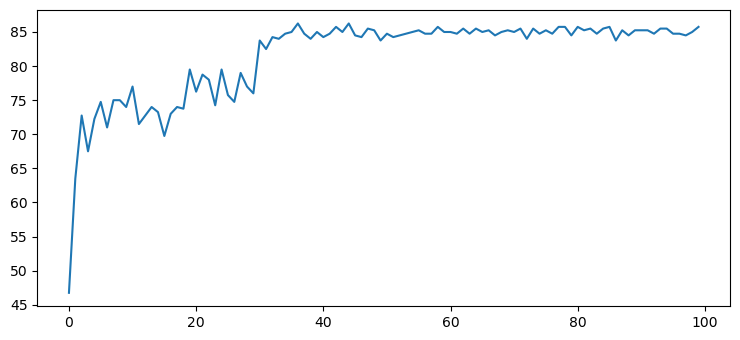

In [31]:
plt.plot(acc_arr[300:400])
plt.show()

In [1]:
# print(model)

In [60]:
# model.load_state_dict(torch.load(PATH))

embed_weights = model.fc
embed_weights

AttributeError: 'ResNet_Mod' object has no attribute 'fc'

In [37]:
print(embed_weights)

Linear(in_features=1024, out_features=50, bias=True)


In [2]:
acc_ssast = [0.04, 0.04, 0.04, 0.0225, 0.0, 0.015, 0.03, 0.0325, 0.03, 0.06, 0.055, 0.0875, 0.115, 0.2225, 0.29, 0.3675, 0.4775, 0.505, 0.6225, 0.6625, 0.68, 0.6975, 0.72, 0.715, 0.7475, 0.735, 0.755, 0.7475, 0.7425, 0.7725, 0.775, 0.76, 0.7975, 0.7925, 0.8, 0.7875, 0.7875, 0.79, 0.7875, 0.795, 0.78, 0.7925, 0.79, 0.7875, 0.7825, 0.775, 0.78, 0.7875, 0.7825, 0.79, 0.79, 0.795, 0.79, 0.79, 0.785, 0.7875, 0.7925, 0.7925, 0.7925, 0.7925, 0.7925, 0.785, 0.785, 0.7875, 0.79, 0.785, 0.7875, 0.7925, 0.79, 0.785, 0.785, 0.79, 0.7875, 0.7875, 0.785, 0.7925, 0.7925, 0.78, 0.7875, 0.785, 0.79, 0.7825, 0.78, 0.78, 0.78, 0.7825, 0.7825, 0.7825, 0.7775, 0.7775, 0.7825, 0.78, 0.78, 0.78, 0.7775, 0.7775, 0.78, 0.78, 0.78, 0.78]

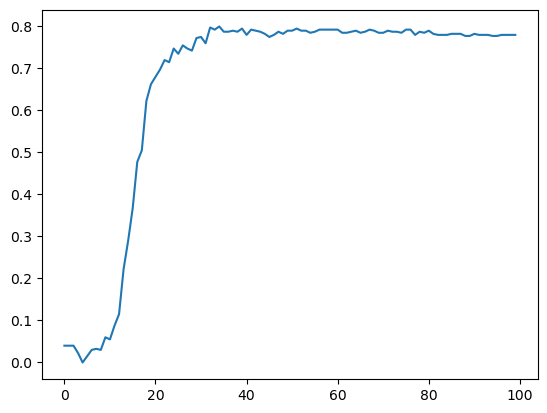

In [6]:
import matplotlib.pyplot as plt
plt.plot(acc_ssast)
plt.show()